In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read data

In [2]:
df = pd.read_csv('2021/MG.csv')
print(df.shape)
print(df.dropna().shape)
df.head()

feature = 'Ua'

#df=pd.read_csv('../../ARIMA-Temperature_Forecasting/MaunaLoaDailyTemps.csv',index_col='DATE',parse_dates=True)
#df=df.dropna()
#print('Shape of data',df.shape)
#df.head()

(8760, 16)
(8041, 16)


<AxesSubplot:>

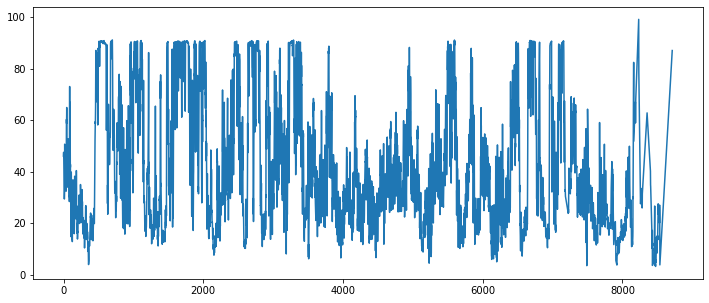

In [3]:
df[feature].dropna().plot(figsize=(12,5))

## Check for stationarity (p-value should be less than 0.05)

In [4]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)
        
adf_test(df[feature].dropna())

1. ADF :  -8.502216083464088
2. P-Value :  1.229579682411578e-13
3. Num Of Lags :  27
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 8017
5. Critical Values :
	 1% :  -3.431165940505994
	 5% :  -2.8619005873457284
	 10% :  -2.566961935933696


## Figure out order for ARIMA model

In [5]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(df[feature].dropna(), 
                          suppress_warnings=True)           

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8045
Model:               SARIMAX(2, 1, 1)   Log Likelihood              -24701.221
Date:                Mon, 18 Apr 2022   AIC                          49410.441
Time:                        15:26:28   BIC                          49438.412
Sample:                             0   HQIC                         49420.013
                               - 8045                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1282      0.009    124.999      0.000       1.111       1.146
ar.L2         -0.2153      0.006    -34.764      0.000      -0.227      -0.203
ma.L1         -0.9564      0.008   -126.124      0.000      -0.971      -0.942
sigma2        27.2110      0.151    179.793      0.000      26.914      27.508
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             93198.12
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Define order based on the output of auto_arima

In [6]:
print(stepwise_fit.order)
order = stepwise_fit.order

(2, 1, 1)


## Split Data into Training and Testing

In [7]:
df_dropna = df.dropna()
print(df_dropna.shape)
test_samples_num = int(0.04 * df_dropna.shape[0])
train = df_dropna.iloc[:-test_samples_num]
test = df_dropna.iloc[-test_samples_num:]
print(train.shape, test.shape)

(8041, 16)
(7720, 16) (321, 16)


## Train the ARIMA model and perform rolling predictions on test set

In [9]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

history = list(train[feature])
predictions = list()
print(len(test))
for t in test[feature].index:
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast()
    predictions.append(output[0])
    #history.append(output[0])
    history.append(test[feature][t])
    print('predicted=%f, expected=%f' % (output[0], test[feature][t]))
    
# evaluate forecasts
rmse = sqrt(mean_squared_error(test[feature], predictions))
print('Test RMSE: %.3f' % rmse)

321
predicted=3.678883, expected=3.750000
predicted=3.850656, expected=6.000000
predicted=6.484829, expected=5.900000
predicted=5.747432, expected=7.900000
predicted=8.373365, expected=8.000000
predicted=7.896022, expected=8.000000
predicted=8.022920, expected=7.940000
predicted=7.921628, expected=8.200000
predicted=8.261615, expected=7.960000
predicted=7.891112, expected=7.730000
predicted=7.697546, expected=8.220000
predicted=8.336650, expected=8.040000
predicted=7.969628, expected=9.680000
predicted=10.056489, expected=11.810000
predicted=12.175508, expected=14.020000
predicted=14.401295, expected=14.420000
predicted=14.400937, expected=14.330000
predicted=14.311170, expected=10.200000
predicted=9.301410, expected=9.700000
predicted=9.832337, expected=9.770000
predicted=9.759508, expected=9.830000
predicted=9.844901, expected=9.550000
predicted=9.484797, expected=8.460000
predicted=8.238868, expected=9.100000
predicted=9.300175, expected=8.900000
predicted=8.804867, expected=9.13000

predicted=12.667379, expected=12.910000
predicted=12.963295, expected=12.370000
predicted=12.238005, expected=12.230000
predicted=12.234200, expected=11.640000
predicted=11.512169, expected=12.390000
predicted=12.588368, expected=12.030000
predicted=11.899961, expected=13.400000
predicted=13.731097, expected=14.870000
predicted=15.103599, expected=16.840000
predicted=17.201755, expected=30.160000
predicted=32.968762, expected=29.550000
predicted=28.653817, expected=82.400000
predicted=94.078427, expected=51.800000
predicted=42.788762, expected=67.000000
predicted=71.389543, expected=59.200000
predicted=55.652936, expected=58.900000
predicted=57.205865, expected=59.300000
predicted=57.821463, expected=63.700000
predicted=63.002550, expected=64.300000
predicted=62.757729, expected=68.170000
predicted=67.270388, expected=99.100000
predicted=103.059224, expected=80.200000
predicted=73.639220, expected=78.400000
predicted=75.981125, expected=30.030000
predicted=19.383323, expected=28.950000

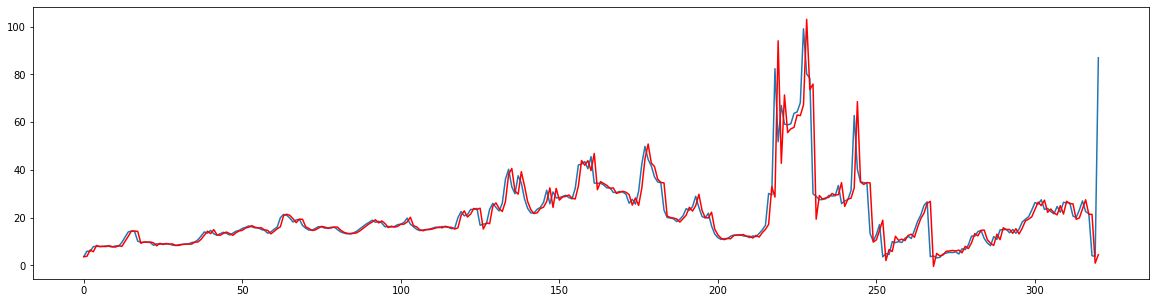

In [11]:
# plot forecasts against actual outcomes
fig = plt.figure(figsize=(20,5))
plt.plot(np.arange(len(test)), test[feature])
plt.plot(predictions, color='red')
plt.show()

## Test residuals

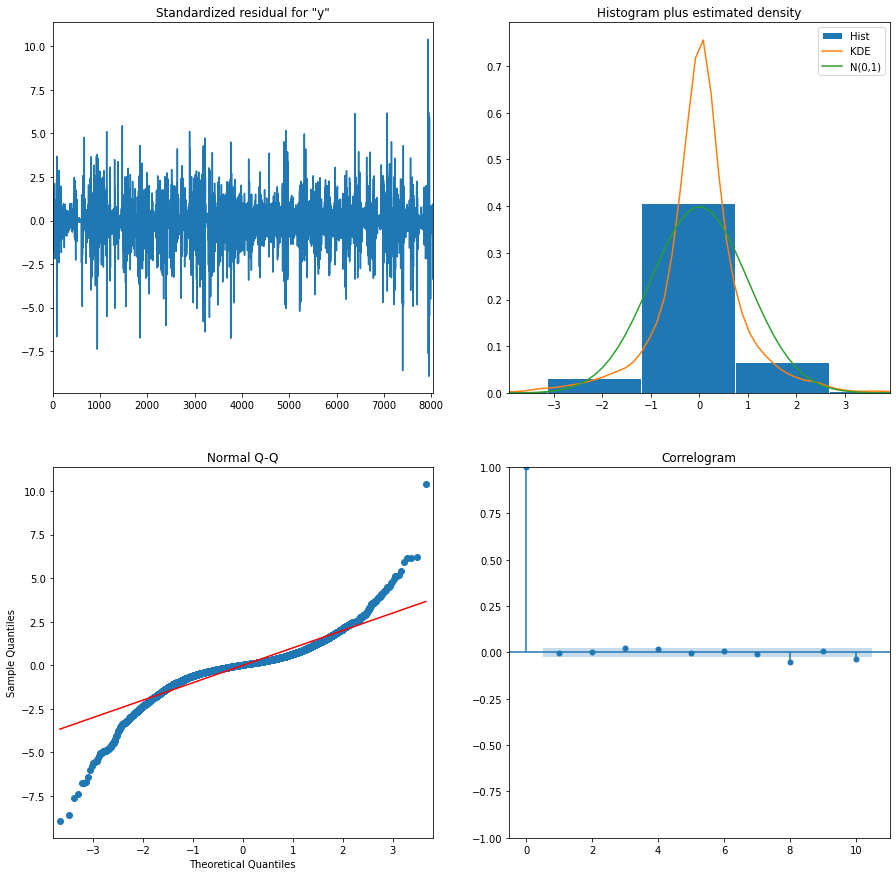

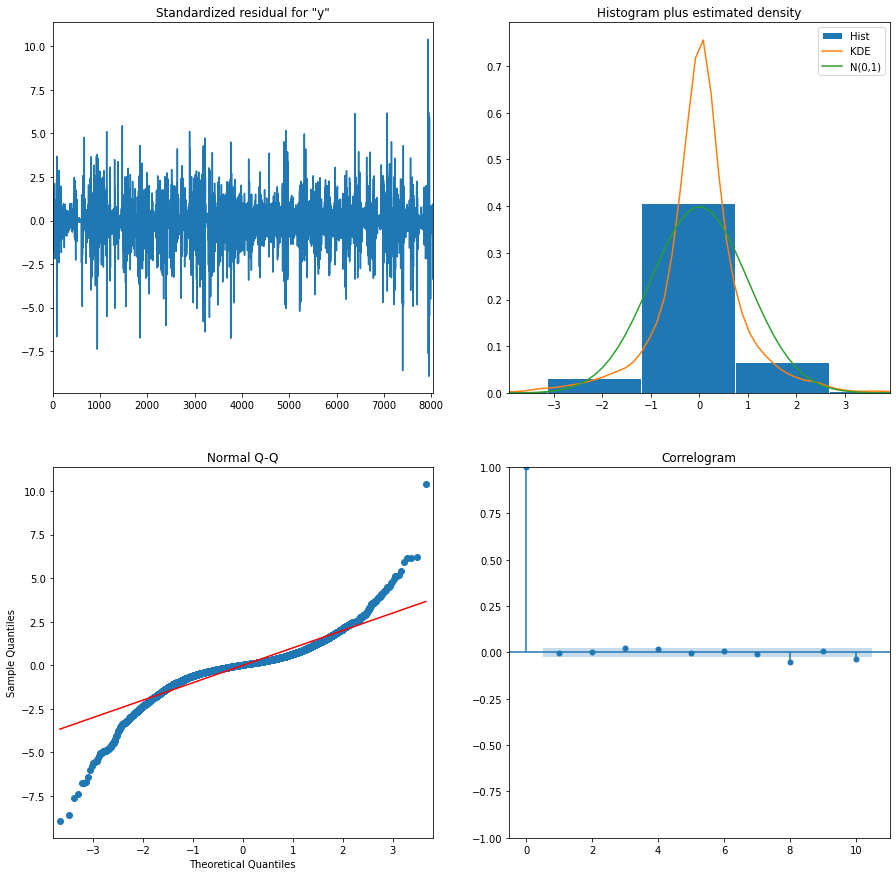

In [12]:
# Plot residual errors
model_fit.plot_diagnostics(figsize=(15,15))